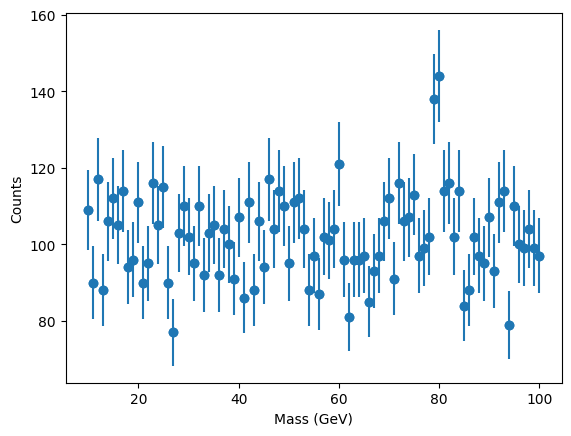

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def getDataPoints(name):
    m = []
    n = []
    errs = []
    fdata = open(name,'r')
    for line in fdata.readlines():
        if line[0] == "#": continue
        m.append(int(line.split()[0]))
        counts = int(line.split()[1])
        n.append(counts)
        errs.append(np.sqrt(counts))
    # convert to numpy arrays
    m1 = np.array(m)
    n1 = np.array(n)
    e1 = np.array(errs)
    return m1, n1, e1

ms, counts, errs = getDataPoints('bump_hunt.txt')

plt.scatter(ms,counts)
plt.errorbar(ms, counts, yerr=errs, fmt="o")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.show()

Bkg-only estimate = 100.9
Signal best-fit: 100.0 + (norm 103.9, mass 79.7, width 0.9)


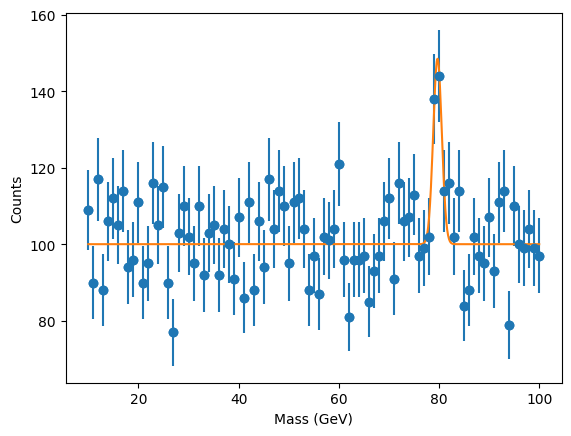

Bkg-only probability 3.69979e-154
Sig+bkg probability 4.82322e-153
Odds ratio 13.0


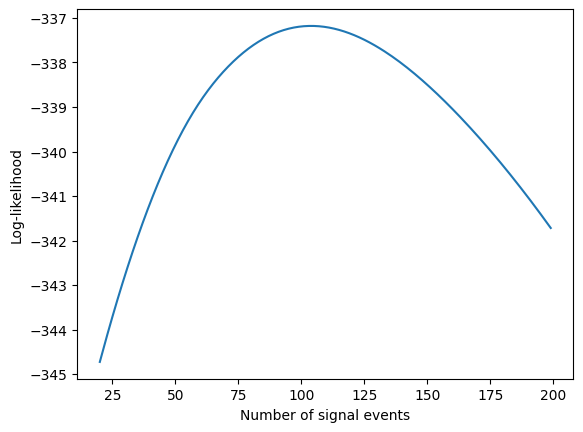

Number of signal events = 103.9 +/- 26.0


In [4]:
limits_bkg = [[50,150]]
limits_sig = [[50,150], [0,400],[10,100],[0.5,5]]

def fitfunc(x, b, norm, m, width):
    return b+(norm/(2.*np.pi*width**2)**0.5)*np.exp(-(x-m)**2/(2*width**2))

def prior(params):
    ret = 1
    for i in range(len(params)):
        if params[i] < limits_sig[i][0] or params[i] > limits_sig[i][1]:
            return 0.
        else:
            ret /= (limits_sig[i][1]-limits_sig[i][0])
    return ret

def loglikelihood_bkgonly(params, xi, yi):
    b = params[0]
    lnL = 0.
    for i in range(len(xi)):
        lnL -= 0.5*(np.log(2*np.pi*yi[i]) + (yi[i]-b)**2/yi[i])
    return -lnL # return -lnL so it can be minimized

def loglikelihood_signal(params, xi, yi):
    b = params[0]
    norm = params[1]
    m = params[2]
    width = params[3]
        
    lnL = 0.
    for i in range(len(xi)):
        mean = fitfunc(xi[i], b, norm, m, width)
        lnL -= 0.5*(np.log(2*np.pi*yi[i]) + (yi[i]-mean)**2/yi[i])
    return -lnL # return -lnL so it can be minimized

def loglikelihood_signal_fixnorm(params, norm, xi, yi):
    b = params[0]
    m = params[1]
    width = params[2]
        
    lnL = 0.
    for i in range(len(xi)):
        mean = fitfunc(xi[i], b, norm, m, width)
        lnL -= 0.5*(np.log(2*np.pi*yi[i]) + (yi[i]-mean)**2/yi[i])
    return -lnL # return -lnL so it can be minimized

def pdfbkg(b, xi, yi):
    params = [b]
    lnL = -loglikelihood_bkgonly(params, xi, yi)
    lnprior = np.log(prior(params))
    return np.exp(lnL+lnprior)

def pdfsig(b, norm, m, width, xi, yi):
    params = [b, norm, m, width]
    lnL = -loglikelihood_signal(params, xi, yi)
    lnprior = np.log(prior(params))
    return np.exp(lnL+lnprior)

# We want to find the maximum likelihood for the background-only and signal+background models
bkgonlyfit = scipy.optimize.minimize(loglikelihood_bkgonly, [150.], args=(ms,counts), method='BFGS')
print("Bkg-only estimate = %1.1f" % bkgonlyfit.x[0])
# Fit performance is poor, vary the seed
minll = 99999.
sigbkgfit = None
for mass in range(10, 100, 5):
    tmp = scipy.optimize.minimize(loglikelihood_signal, [bkgonlyfit.x[0], 0., mass, 5.], args=(ms,counts), method='BFGS')
    ll = loglikelihood_signal(tmp.x, ms, counts)
    if ll < minll:
        sigbkgfit = tmp
        minll = ll

xlin = np.linspace(10., 100., 1000)
bestfit = fitfunc(xlin, sigbkgfit.x[0], sigbkgfit.x[1], sigbkgfit.x[2], sigbkgfit.x[3])
print("Signal best-fit: %1.1f + (norm %1.1f, mass %1.1f, width %1.1f)" % 
      (sigbkgfit.x[0], sigbkgfit.x[1], sigbkgfit.x[2], sigbkgfit.x[3]))

plt.scatter(ms,counts)
plt.errorbar(ms, counts, yerr=errs, fmt="o")
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.plot(xlin, bestfit)
plt.show()

# 1D integral for the background-only model
prob1d, err1d = scipy.integrate.nquad(pdfbkg, limits_bkg, args=(ms,counts))
print("Bkg-only probability %g" % prob1d)

# This is a 4D integral, this will take a super duper long time
prob3d, err3d = scipy.integrate.nquad(pdfsig, limits_sig, args=(ms,counts))
print("Sig+bkg probability %g" % prob3d)
print("Odds ratio %1.1f" % (prob3d/prob1d))


# Determine the uncertainty on the number of signal events, i.e. the "norm" parameter
lnL_vs_norm = []
norms = [i for i in range(int(0.2*sigbkgfit.x[0]), int(2.*sigbkgfit.x[0]))]
for norm in norms:
    # Find the best-fit of the other three parameters at each point
    # To do this completely correctly, we should marginalize over the other parameters
    # This would be computationally awful, and this is a reasonable approximation
    tmp = scipy.optimize.minimize(loglikelihood_signal_fixnorm, [sigbkgfit.x[0], sigbkgfit.x[2], sigbkgfit.x[3]], args=(norm,ms,counts))
    ll = loglikelihood_signal_fixnorm(tmp.x, norm, ms, counts)
    lnL_vs_norm.append(-ll)
    
plt.plot(norms, lnL_vs_norm)
plt.xlabel("Number of signal events")
plt.ylabel("Log-likelihood")
plt.show()

#Find range of lnL-0.5
maxLL = -minll
low = None
high = None
for i,norm in enumerate(norms):
    if low is None and lnL_vs_norm[i]>maxLL-0.5:
        low = norm
    if low is not None and high is None and lnL_vs_norm[i]<maxLL-0.5:
        high = norm
sig_err = (high-low)/2.

print("Number of signal events = %1.1f +/- %1.1f" % (sigbkgfit.x[1], sig_err))



In the above Bayesian framework, we evaluate the Bayes factor

\begin{equation}
B_{10} = \frac{\int db dN dm d\sigma P(D|M_{1}(b, N, m, \sigma))}{\int db P(D|M_{0}(b))},
\end{equation}

where M_{0} is the null hypothesis (background only) with unknown background rate $b$, M_{1} is a model that includes the background as well as $N$ signal events, distributed as a Gaussian centered at mass $m$ with standard deviation $\sigma$. The model parameters are marginalized.

The Bayes factor is $\sim 30$ desipite a significant Occam penalty given the three additional free parameters. The exact number will depend on the prior ranges assumed; we allow the mass to take any value included in the data, and choose a conservative range of the signal parameters.

In [ ]:
def chi2_bkgonly(b, xi, yi):
    chi2 = 0.
    for i in range(len(xi)):
        chi2 += (yi[i]-b)**2/yi[i]
    return chi2

def chi2_signal(params, xi, yi):
    b = params[0]
    norm = params[1]
    m = params[2]
    width = params[3]
    chi2 = 0.
    for i in range(len(xi)):
        model = fitfunc(xi[i], b, norm, m, width)
        chi2 += (yi[i]-model)**2/yi[i]
    return chi2
        
fitbkg = scipy.optimize.minimize(chi2_bkgonly, bkgonlyfit.x[0], args=(ms, counts), method='BFGS')
chi2_bkg = chi2_bkgonly(fitbkg.x[0], ms, counts)

fitsig = scipy.optimize.minimize(chi2_signal, sigbkgfit.x, args=(ms, counts), method='BFGS')
chi2_sig = chi2_signal(fitsig.x, ms, counts)

bkg_mean = fitsig.x[0]

delta_chi2 = chi2_bkg - chi2_sig
pvaldiff = scipy.stats.chi2.sf(delta_chi2, 3)

print("DeltaChi2 = %1.1f - %1.1f = %1.1f" % (chi2_bkg, chi2_sig, delta_chi2))
print("p-value for 3 dof = %g" % pvaldiff)

bnds = [[0.,999.], [0., 999.], [10., 100.], [0., 10.]]

# Feldman-Cousins
chi2_dist = []
for i in range(200000):
    if not i%1000: print("Throw %d" % i)
        
    fccounts = np.random.normal(bkg_mean, np.sqrt(bkg_mean), len(ms))

    fcfitbkg = scipy.optimize.minimize(chi2_bkgonly, bkg_mean, args=(ms,fccounts), method='BFGS')

    minchi2 = 99999.
    fcfitsig = None
    for mass in range(15, 100, 5):
        tmp = scipy.optimize.minimize(chi2_signal, [bkg_mean, 0., mass, 1.], 
                                      args=(ms,fccounts), method='L-BFGS-B', bounds=bnds)
        c2 = chi2_signal(tmp.x, ms, fccounts)
        if c2 < minchi2:
            fcfitsig = tmp
            minchi2 = c2
    
    chi2_bkgfc = chi2_bkgonly(fcfitbkg.x[0], ms, fccounts)
    chi2_sigfc = chi2_signal(fcfitsig.x, ms, fccounts)
    chi2_dist.append(chi2_bkgfc - chi2_sigfc)

    if chi2_bkgfc - chi2_sigfc > delta_chi2:
        bf = fitfunc(ms, fcfitsig.x[0], fcfitsig.x[1], fcfitsig.x[2], fcfitsig.x[3])
        plt.scatter(ms,fccounts)
        plt.plot(ms,bf)
        plt.show()
    
plt.hist(chi2_dist,100,histtype='step')
plt.xlabel("Delta Chi2")
plt.ylabel("Number of pseudoexperiments")
plt.show()

chi2_dist.sort()
n_below = 0
while n_below < len(chi2_dist) and chi2_dist[n_below] < delta_chi2:
    n_below += 1

print("%d of %d throws are below %f" % (n_below, len(chi2_dist), delta_chi2))
print("Significance of result = %1.3f%%" % (100.*n_below/len(chi2_dist)))

DeltaChi2 = 111.6 - 86.7 = 25.0
p-value for 3 dof = 1.57846e-05
Throw 0


C:\Users\andre\AppData\Local\Temp\ipykernel_13236\2312886112.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return b+(norm/(2.*np.pi*width**2)**0.5)*np.exp(-(x-m)**2/(2*width**2))
C:\Users\andre\AppData\Local\Temp\ipykernel_13236\2312886112.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  return b+(norm/(2.*np.pi*width**2)**0.5)*np.exp(-(x-m)**2/(2*width**2))
C:\Users\andre\AppData\Local\Temp\ipykernel_13236\2312886112.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return b+(norm/(2.*np.pi*width**2)**0.5)*np.exp(-(x-m)**2/(2*width**2))


Throw 1000
Throw 2000
Throw 3000


In the above frequentist analysis, we use a $\chi^{2}$ test statistic for both the background-only and background+signal models. We obtain a $\Delta \chi^{2}$ of 25.1. The two models are nested because the background-only model can be obtained from the signal+background model by setting the normalization parameter to zero. Given the high statistics, and the fact that none of the parameters ($b$, $m$, $N$, $\sigma$) of the signal model are near physical boundaries, we can expect Wilks's theorem to be valid. We can therefore compute a p-value from a $\chi^{2}$ distribution with 3 degrees of freedom. We find a p-value of $1.5 \times 10^{-5}$, corresponding to a $\sim 4.1\sigma$ significance of the signal. The p-value can be interpreted as the probability that a background fluctuation at least this large would be observed anywhere in the allowed mass range.

To confirm the result, we perform a Feldman-Cousins analysis, where we randomly throw the null model many times. Based on the p-value recorded, we can expect only a few in $10^{5}$ pseudo-experiments to have this large a $\Delta \chi^{2}$, so we need to simulate a large number of throws. The above code takes many hours to run. All we can say about this result is that is consistent with what is obtained from Wilks's theorem. To make a more precise statement would require a statistically significant number of simulated background fluctuations. A 10% measurement of the critial $\Delta \chi^{2}$ would require $\sim 100 \times 10^{5} \approx 10^{7}$ throws and would take days to run on a laptop. However, on the NERSC supercomputer, with hundreds of thousands of concurrent processes, it could be run in a minute or so.